# Example Airyscan

Example of flow meausurement with the Airyscan. Sample: 80 nM ATTO488 in a flow chamber under 62.5 mbar. Measurement near the center of the well.

See "Dilissen S., et al., BBA - General Subjects, 2024."

Load packages

In [1]:
from brighteyes_ffs.fcs.fcs2corr import fcs_load_and_corr_split as correlate
from brighteyes_ffs.fcs.fcs2corr import fcs_av_chunks
from brighteyes_ffs.fcs.fcs_fit import fcs_fit
from brighteyes_ffs.fcs.get_fcs_info import get_metafile_from_file, get_file_info
from brighteyes_ffs.fcs.plot_fingerprint import plot_fingerprint_airyscan
from brighteyes_ffs.fcs.fcs_polar import g2flow
import matplotlib.pyplot as plt
import numpy as np

File name and correlation options to calculate.

list_of_g is a list of correlations to calculate. 'crossAll' is a predefined keyword which will calculate all cross-correlations

averaging is a list of correlations to average, which can be done for correlations between pairs of detector elements with similar relative positions.

list_of_g_out is a list where you can choose the names of the averaged correlations. E.g., 'Angle0' means the average cross-correlation of all pairs with relative shifts in the horizontal direction, only.

In [2]:
file = "D:/20231511_M1_ATTO488_80nM_62-5mBar_1485_Z-001_4.h5"
list_of_g = ['crossAll']
list_of_g_out = ['Angle0', 'Angle60', 'Angle120', 'Angle180', 'Angle240', 'Angle300']
averaging = ['0x18+3x6+12x0+2x7+11x1+10x8+4x17+13x5+14x16', '0x16+2x5+10x0+1x17+9x6+8x18+3x15+11x4+12x14', '0x14+1x4+8x0+2x13+9x3+10x12+6x15+7x5+18x16', '0x12+6x3+18x0+17x4+5x13+16x14+7x2+1x11+8x10', '0x10+5x2+16x0+6x9+17x1+18x8+15x3+4x11+14x12', '0x8+4x1+14x0+3x9+13x2+12x10+5x7+15x6+16x18']
algorithm = 'sparse_matrices' #'sparse_matrices' for fast time-domain calculation
resolution = 20 #the higher this number, the more points the correlation will have
chunksize = 0.2 # split the data in segments of this length (in seconds) and calculate the ACF for each segment separately
time_trace = True # return the intensity time trace

In [3]:
mdata = get_file_info(get_metafile_from_file(file))

Calculate correlations

In [4]:
G, time_trace = correlate(file, list_of_g=list_of_g, accuracy=resolution, split=chunksize, time_trace=True, averaging=averaging, list_of_g_out=list_of_g_out, algorithm=algorithm)

+--------------------+
| Loading chunk 1/73 |
+--------------------+
(12320768, 32)
     --> crossAll: Calculating all crosscorrelations with sparse matrices algorithm
+--------------------+
| Loading chunk 2/73 |
+--------------------+
(12320768, 32)
     --> crossAll: Calculating all crosscorrelations with sparse matrices algorithm
+--------------------+
| Loading chunk 3/73 |
+--------------------+
(12320768, 32)
     --> crossAll: Calculating all crosscorrelations with sparse matrices algorithm
+--------------------+
| Loading chunk 4/73 |
+--------------------+
(12320768, 32)
     --> crossAll: Calculating all crosscorrelations with sparse matrices algorithm
+--------------------+
| Loading chunk 5/73 |
+--------------------+
(12320768, 32)
     --> crossAll: Calculating all crosscorrelations with sparse matrices algorithm
+--------------------+
| Loading chunk 6/73 |
+--------------------+
(12320768, 32)
     --> crossAll: Calculating all crosscorrelations with sparse matrices al

### Plot time trace

In [5]:
num_chunks = int(np.floor(mdata.duration / chunksize))
splits = np.arange(0, (num_chunks+1)*chunksize, chunksize)
good_chunks = [i for i in range(num_chunks)]

Text(0, 0.5, 'Photon counts per bin')

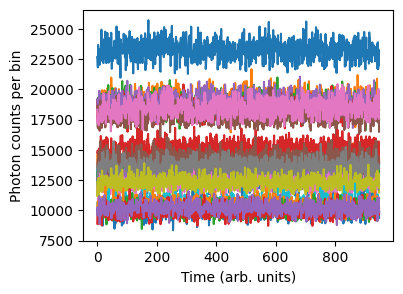

In [14]:
fig, ax = plt.subplots(figsize=(4,3))
for i in range(25):
    plt.plot(time_trace[:-51,i])
ymin = np.min(time_trace)
ymax = np.max(time_trace)
plt.xlabel('Time (arb. units)')
plt.ylabel('Photon counts per bin')

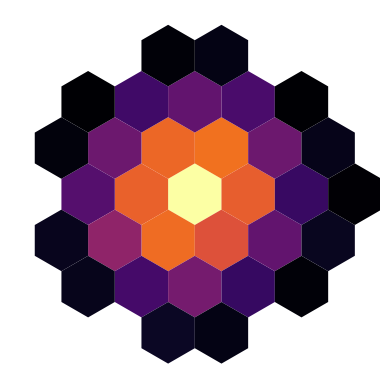

In [10]:
sx, sy, cc = plot_fingerprint_airyscan(np.sum(time_trace, 0), plot=True)

### Plot correlations  

In [15]:
G.average_chunks(good_chunks)

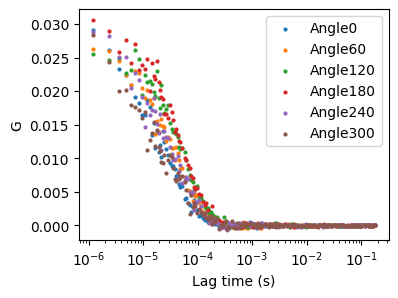

In [17]:
plt.figure(figsize=(4,3))
for corr in list_of_g_out:
    Gsingle = getattr(G, corr + '_averageX')
    plt.scatter(Gsingle[1:,0], Gsingle[1:,1], s=4, label=corr)
plt.legend()
plt.xlabel('Lag time (s)')
plt.ylabel('G')
plt.xscale('log')

The correlations look different for different directions, indicating flow. This can also be visualized with a polar plot.

In [18]:
corrs = np.zeros((len(Gsingle), len(list_of_g_out)))
for i, corr in enumerate(list_of_g_out):
    corrs[:, i] = getattr(G, corr + '_averageX')[:,1]
z, arrow = g2flow(corrs[1:85,:], detector='airy6')
R = len(z) / 2
phi = np.linspace(0, 2*np.pi, 360)
r = 2*arrow[1]
u = 2*arrow[0]

(-9.0, 189.0, -9.0, 189.0)

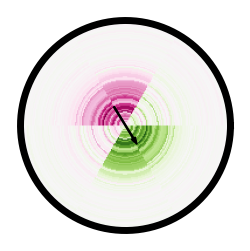

In [19]:
plt.figure(figsize=(3,3))
plt.imshow(np.flipud(z), cmap='PiYG')
plt.arrow(90-(r/2), 90-(u/2), r, u, width=1, head_width=4, color='k', length_includes_head=True)
plt.plot(R*np.cos(phi) + R, R*np.sin(phi)+R, '-', color='k', linewidth=5)
plt.xlim([-0.1*R, 2.1*R])
plt.ylim([-0.1*R, 2.1*R])
plt.axis('off')

### Fit correlations 

To quantify the flow speed, fit the correlations with a global fit.

For fitfun = 'fcs_fit_dualfocus', the order of the 9 parameters for fitting is
* c: emitter concentration [/um^3]
* D: diffusion coefficient [um^2/s]
* w0: beam waist [nm]
* SF: shape factor [dim.less]
* rho_x, rho_y: distance in x,y direction between each pair of detector elements [nm]
* v_x, v_y: flow speed in x,y direction [um/s]
* offset

We fit c, D, w0, v_x, and v_y in a global fit. The parameters rho_x and rho_y are different for each of the 6 curves.

In [20]:
from brighteyes_ffs.fcs.fcs_fit import fcs_fit_dualfocus as my_fit_fun # you chose Free diffusion with flow - global fit as the fit function

In [38]:
# order of parameters:     N      D      w0     SF     rhox   rhoy   vx     vy     offset
fit_info     = np.asarray([True,  True,  False, False, False, False, True,  True,  False])
global_param = np.asarray([True,  True,  False, False, False, False, True,  True,  False])
lbounds      = np.asarray([0,     1e-3,  0.05,  0,     -1e6,  -1e6,  -1e9,  -1e9,  -100.0]) # the lower bounds for the fit parameters
ubounds      = np.asarray([1e6,   1e3,   1e4,   1e6,   1e6,   1e6,   1e9,   1e9,   1e6]) # the upper bounds for the fit parameters

rho_x        = np.asarray([0.0,   103.0, 103.0, 0.0,   -103.0, -103.0]) # horizontal displacement between detector elements (nm)
rho_y        = np.asarray([119.0, 59.0, -59.0, -119.0, -59.0, 59.0]) # vertical displacement between detector elements (nm)

start_idx = 3
stop_idx = 85

param = np.zeros((len(fit_info), len(list_of_g_out)))
G_all = []
for i, corr in enumerate(list_of_g_out):
    param[:, i] = np.asarray([1, 250, 206, 5.0, rho_x[i], rho_y[i], 0, 0, 0]) # order of parameters: N, D, w0, SF, rhox, rhoy, vx, vy, offset
    G_all.append(getattr(G, corr+'_averageX')[:,1])
    tau = getattr(G, corr+'_averageX')[:,0]
G_all = np.transpose(np.asarray(G_all))

In [39]:
fitresult = fcs_fit(G_all[start_idx:stop_idx,:], tau[start_idx:stop_idx], my_fit_fun, fit_info, param, lbounds, ubounds, plotInfo=-1, global_param=global_param)

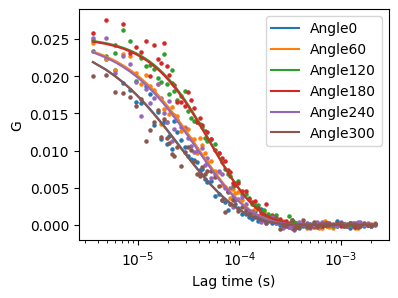

In [40]:
plt.figure(figsize=(4,3))
for f, corr in enumerate(list_of_g_out):
    Gsingle = getattr(G, corr + '_averageX')
    plt.scatter(tau[start_idx:stop_idx], G_all[start_idx:stop_idx,f], s=5)
    plt.plot(tau[start_idx:stop_idx], G_all[start_idx:stop_idx,f]-fitresult.fun[:,f], label=corr)
plt.xscale('log')
plt.xlabel('Lag time (s)')
plt.ylabel('G')
plt.legend()

In [41]:
fitted_speed = np.sqrt(fitresult.x[6,0]**2 + fitresult.x[7,0]**2)
print(f"fitted speed: {fitted_speed:.1f} um/s")

fitted speed: 3868.1 um/s


The following table gives the parameter values for all (both fitted and fixed) parameters.

In [42]:
for row in fitresult.x:
    print("".join(f"{v:{12}.2f}" for v in row))

       28.30       28.30       28.30       28.30       28.30       28.30
      360.32      360.32      360.32      360.32      360.32      360.32
      206.00      206.00      206.00      206.00      206.00      206.00
        5.00        5.00        5.00        5.00        5.00        5.00
        0.00      103.00      103.00        0.00     -103.00     -103.00
      119.00       59.00      -59.00     -119.00      -59.00       59.00
     2055.61     2055.61     2055.61     2055.61     2055.61     2055.61
    -3276.72    -3276.72    -3276.72    -3276.72    -3276.72    -3276.72
        0.00        0.00        0.00        0.00        0.00        0.00
